# Signal Chain Analysis in Python

**A Case Study for Electronics Engineers**

**Gael Close**


This notebook is an appendix to the following article:

* G. Close, “Signal chain analysis in python: a case study for hardware engineers,” Towards Data Science, 22-Feb-2021. Available: https://towardsdatascience.com/signal-chain-analysis-in-python-84513fcf7db2. 

The illustrative functional block diagram analyzed in the article is shown below.


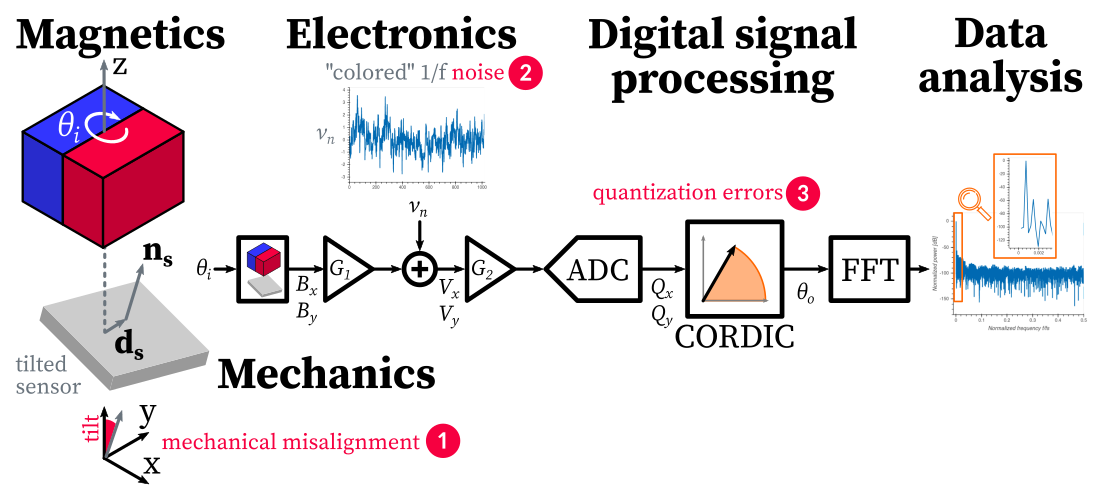

In [2]:
from IPython.display import Image
Image("illustrative_example.png", width=1000)

## All function definitions

All import and functions used throughout the notebook are defined here.

In [1]:
## Init cell containing all definitions
# Common package
import numpy as np
import scipy
import pandas as pd
import holoviews as hv
import hvplot.pandas
import panel as pn
pn.extension()
#To test: pn.Column("## Title", pd.DataFrame(np.random.randn(100, 2)).cumsum().hvplot())

# Specific to this analyis
from magpylib.source.magnet import Box as Bar_magnet
from scipy.spatial.transform import Rotation as R
from scipy import signal
import yaml
from box import Box
from mergedeep import merge
from magpylib.source.magnet import Box as Bar_magnet

def deg_180(x):
  '''wrap angle in [-180,180] deg'''
  return(((x + 180) % (360)) - 180)

#----------------------
# Constants
#----------------------
FIG_WIDTH=400

#----------------------
# Function wrapper
#----------------------

def apply_func_df(func):
  def wrapper(df, dd, **kwargs):
    Y = df.apply(func, dd=dd, **kwargs, axis=1, result_type='expand')
    return df.drop(columns=Y.columns, errors='ignore').join(Y)
  wrapper.__wrapped__ = func
  return wrapper

#----------------------
# Parameters
#----------------------

def load_dd():
  return Box({
    'magnet'  : {
      'dim'   : [10,10,10],  # magnet dimension Lx, Ly, Lz [mm]
      'mag'   : [-1,0,0],    # magnetization vector Br [Tesla]  
      'pos'   : [0,0,15] },  # magnet center [mm] 
    'sensor'  : {
      'pos'   : [0,1,0],     # sensor center [mm]
      'tilt'  : 3,           # sensor tilt [°]
      'S'     : 1.0,         # sensor sensitivity [Volt/Telsa]
      'noise' : 0.2 },       # sensor input-referred noise [Tesla]
    'adc': {
       'lsb'  : 0.1,         # ADC LSB size rounding step
       'n'    : 12 },        # ADC number of bits 
    'cordic'  : {
      'n'     : 12, }        # CORDIC number of iterations 
  })

def calc_derived(dd):
  dd.sensor.airgap =dd.magnet.pos[2] - dd.magnet.dim[2]
  dd.sensor.rot=R.from_euler('y', dd.sensor.tilt, degrees=True)

#----------------------
# Magnet
#----------------------


@apply_func_df
def calc_B_vs_z(X, dd):
  'Calculate the field vector in mT as a function of z'
  B = magnet.getB(np.array(dd.sensor.pos) + np.array([0,0,X.z]))/1e-3
  return {'Bx': B[0], 'By': B[1], 'Bz': B[2]}

@apply_func_df
def calc_B(X, dd, magnet):
  'Calculate the field vector in mT as a function of rotation'
  magnet.rotate(angle=X.theta_i, axis=[0,0,1])
  B = magnet.getB(np.array(dd.sensor.pos))/1e-3
  magnet.angle=0
  B=dd.sensor.rot.apply(B)
  return {'Bx': B[0], 'By': B[1], 'Bz': B[2]}


#----------------------
# Electronics
#----------------------
import colorednoise as cn

def apply_noise(df, dd):
  noise=pd.DataFrame([pd.Series(cn.powerlaw_psd_gaussian(1, len(df))) for k in np.arange(2)]).T
  noise*=dd.sensor.noise
  df[['Bx', 'By']] +=noise.values
  return df

@apply_func_df
def transduce(X, dd):
  return {
    'Vx': X.Bx * dd['sensor']['S'],
    'Vy': X.By * dd['sensor']['S'],
    }

@apply_func_df
def quantize(X, dd):
  def q(v): 
    return np.clip(int(v/dd.adc.lsb), -2**(dd.adc.n-1), 2**(dd.adc.n-1))
  return {'Qx': q(X.Vx), 'Qy': q(X.Vy)}

#-------------------------
# Angle calculation
#------------------------
#url = "https://people.sc.fsu.edu/~jburkardt/py_src/cordic/cordic.py"
#!wget {url} -O cordic.py
import cordic


@apply_func_df
def calc_angle(X, dd):
  x,y = X.Qx, X.Qy
  angle = cordic.arctan_cordic(x, y, n=dd.cordic.n)
  # 4-quadrant extension
  return {'theta_o': np.degrees(np.sign(x)**2 * angle + (1-np.sign(x))/2*(1+np.sign(y)-np.sign(y)**2)*np.pi)}

#-------------------------------------------
# Virtual experiment with complete chain
#-------------------------------------------

def virtual_experiment(theta_i=np.arange(0,360,0.1), dd={}):
  dd=merge(load_dd(), dd)
  calc_derived(dd)
  magnet=Bar_magnet(**dd.magnet)
  
  df = pd.DataFrame({'theta_i': theta_i})
  df=(df.pipe(calc_B, dd=dd, magnet=magnet)
      .pipe(transduce,dd=dd)
      .pipe(apply_noise, dd=dd)
      .pipe(quantize, dd=dd)
      .pipe(calc_angle, dd=dd))
  df['theta_err'] = deg_180(df.theta_o - df.theta_i)
  df['theta_err'] -= df['theta_err'].mean()
  return df

#-------------------------------------------
# ENOB
#-------------------------------------------
N_FFT=2**12

def ENOB(ser, full_scale=None):
  '''
  Calculate ENOB and related power quantities (Signal, Distortion, ...).
  
  Args:
  - ser: series containing the output waveform (a distorted/noisy sinewave)
  - full_scale: positive full scale (bipolar range assumed: +-full_scale) 
                to be used in SNR/ENOB calculation. 
                If not given, SNR calculation uses the given waveform
  
  Returns:
  
  A dataframe containing the key performance parameters values
    - ENOB in bits
    - d:  √Distortion power
    - n:  √Noise power
  
  And another series containing the spectral power bin in dB below signal (or full scale if given)
  '''
  
  # Spectral analysis
  ser-=ser.mean()
  f, P =  signal.periodogram(ser, scaling='spectrum', detrend=None)
  
  # Power quantities
  idx_max=np.argmax(P)
  S   = P[idx_max]    # Unit energy: rms^2
  D   = sum(P[2*idx_max:11*idx_max:idx_max]) # sum of harmonic components up to order 10
  N   = sum(P) - S - D
  
  # Use full scale for signal if given
  if full_scale:                    
    S = 0.5*full_scale**2
  
  
  # Metrics: see also http://www.ni.com/white-paper/4278/en/  
  # IEEE Standard for Terminology and Test Methods for Analog-to-Digital Converters, IEEE Std 1241-2000.
  SINAD = 10*np.log10(S/(N+D))
  KPP = pd.Series({
    'ENOB': (SINAD - 1.76) / 6.02,
    'd':   np.sqrt(D), 
    'n':   np.sqrt(N),
  }).to_frame('value')
  
  return KPP, pd.DataFrame({'f': f,'Pc': 10*np.log10(P/S)})


## Data dictionary

The following loads the data dictioanry containing all fixed design parameters.

In [4]:
dd=load_dd()
display(pd.DataFrame.from_dict(dd, orient='index')\
        .stack().rename_axis(['component','parameter']).to_frame('value'))

calc_derived(dd)

value
component parameter              
magnet    dim        [10, 10, 10]
          mag          [-1, 0, 0]
          pos          [0, 0, 15]
sensor    pos           [0, 1, 0]
          tilt                3.0
          S                   1.0
          noise               0.2
adc       lsb                 0.1
          n                  12.0
cordic    n                  12.0

## Modeling mechanical and magnetic aspects

Here we calculate and plot the sensed field components.

In [14]:
dd = load_dd()
calc_derived(dd)
magnet=Bar_magnet(**dd.magnet)
df = pd.DataFrame({'theta_i': np.linspace(0,360,2**10, endpoint=False)})
df=calc_B(df, dd, magnet=magnet)   #explicit key word argument for magnet
df['B magn.']=df.filter(regex='B[x,y,z]').apply(np.linalg.norm, axis=1)

df.hvplot(x='theta_i', y=['Bx', 'By', 'B magn.'],
          xlabel='θi [°]', ylabel='Field [mT]')

:NdOverlay   [Variable]
   :Curve   [theta_i]   (value)

### Field vs airgap

As a side note, we plot here the field amplitude over airgap.
This is not part of the main analysis.

In [6]:
df = pd.DataFrame({'z': np.arange(-5,5,0.5)})
df=calc_B_vs_z(df, dd)

df['Bmag']=df.filter(regex='B[x,y,z]').apply(np.linalg.norm, axis=1)
dd.magnet.airgap =dd.magnet.pos[2] - dd.magnet.dim[2]
df['airgap']=dd.magnet.airgap - df.z
df.hvplot(x='airgap', y='Bmag',
          xlabel='airgap [mm]', ylabel='Field magnitude [mT]', width=400,
         )

:Curve   [airgap]   (Bmag)

### Noise modeling and power-spectral density

Here we generate and plot pink noise waveform.
By default they have an RMS amplitude of 1 (see std below).

In [7]:
N = 10
import colorednoise as cn
beta = 1 # the exponent
samples = 2**N # number of samples to generate

noise=pd.DataFrame([pd.Series(cn.powerlaw_psd_gaussian(1, samples)) for k in np.arange(2)]).T

# optionally plot the Power Spectral Density with Matplotlib
from matplotlib import mlab
display(noise.describe())
noise[0].hvplot(width=400)

,0,1
count,1024.000000,1024.000000
mean,-0.124987,-0.179116
std,1.029057,1.039914
min,-3.626314,-3.820073
25%,-0.845039,-0.852836
50%,-0.201725,-0.131060
75%,0.566108,0.525882
max,3.660293,3.318363


:Curve   [index]   (0)

The spectrum has the shape "1/f" as expected.

In [15]:
spectrum=pd.DataFrame(mlab.psd(noise[0], NFFT=2**8, Fs=1), index=['P', 'f']).T
spectrum.iloc[1:].hvplot(x='f', y='P', logx=True, logy=True, 
                xlabel='Normalized frequency', 
                ylabel='Power density [T²/Hz]')

:Curve   [f]   (P)

## Complete chain

The complete chain can be invoked via teh virtual_experiement function.
We plot the angle error for illustration

<AxesSubplot:xlabel='sample [n]', ylabel='angle error [degree]'>

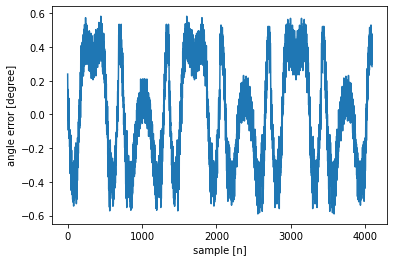

In [16]:
df =virtual_experiment(
  theta_i=180*np.sin(3 * (2*np.pi/(N_FFT) * np.arange(N_FFT))),
  dd={'sensor': dict(pos=[0,1,0])}).reset_index()
df['theta_o']=np.unwrap(df['theta_o'],180)

df.theta_err.plot(xlabel='sample [n]', ylabel='angle error [degree]')

## ENOB analysis

The ENOB analysis has been wrapped into a function. It returns a few metrics.

In [18]:
KPP,dB = ENOB(df.theta_o, full_scale=180)
display(KPP.style.format("{:.2f}"))

,value
ENOB,8.05
d,0.33
n,0.22


## Dashboard

The dashboard consists of a few plots and one summary table.

In [19]:
# A few plots
g1=df.hvplot(y='theta_i',   xlabel='n', ylabel='Angle [°]', width=FIG_WIDTH)
g2=df.hvplot(y='theta_err', xlabel='n', ylabel='Angle [°]', width=FIG_WIDTH)
g3=dB.iloc[1:]\
 .hvplot(y='Pc', x='f', logy=False, logx=False, xlim=[-1e-2,None],
        ylabel = 'Normalized power [dB]',
        xlabel = 'Normalized frequency f/fs', 
        width=FIG_WIDTH
        )

# Format the summary table of key perf. parameters
KPP['units']=['b', '°rms', '°rms']
KPP.index=['ENOB','Distortion', 'Noise']
KPP.value=KPP.value.apply(lambda x: '{:.2f}'.format(x))

# Assemble dashboard
panel=pn.Row(
  pn.Tabs(
    ('Input stimuli', g1),
    ('Sensor error', g2),
    ('Sensor output spectrum', g3)),
  pn.widgets.DataFrame(KPP, name='summary', sortable=False, width=250))
panel.embed()  